In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn import metrics
from matplotlib.colors import LogNorm
import itertools
from scipy import linalg
import matplotlib as mpl
import pandas as pd

In [17]:
def load_data(file_t1 = 'data/T1_point.txt', file_t2 = 'data/T2_point.txt', file_fvol='data/T1T2_1_223_T110c.txt', verbose=0):
    # load raw t1,t2 and fluid volume data from file
    t1_domain = np.loadtxt(file_t1) # 1d minimum points
    t2_domain = np.loadtxt(file_t2) # 1d minimum points
    f_grid = np.loadtxt(file_fvol) # 2d grid points
    t2_grid,t1_grid = np.meshgrid(t2_domain, t1_domain) # 2D grid points
    # check size
    assert(f_grid.size == t2_grid.size)
    assert(f_grid.size == t1_grid.size) 
    increment_t1 = np.log10(t1_domain[0]) - np.log10(t1_domain[1])
    increment_t2 = np.log10(t2_domain[1]) - np.log10(t2_domain[2])
    if verbose:
        print('file info, Grid shape of [t1,t2]: {}, log(t1) incremental: {}, log(t2) incremental: {}'.format(
            f_grid.shape, round(increment_t1,5), round(increment_t2,5)))
    return t1_grid, t2_grid, f_grid

In [19]:
t1_grid, t2_grid, f_grid = load_data()

file info, Grid shape of [t1,t2]: (151, 121), log(t1) incremental: -0.03333, log(t2) incremental: -0.04167


(151, 121)

In [54]:
def to_density(t2_grid, t1_grid, f_grid, min_t1t2_ratio=0.5, t1_max = 600, fc=0.1, variation_length = 0.01, verbose=0):
    """
    Perform 4-steps preprocessing:
        1. Crop the data by selecting t1_grid > t2_grid * min_t1t2_ratio and t1_grid  < max of t1 
        2. Select f_grid > minimum of f = T1T2_max * ratio, and normalize it. 
        3. Log transform of t1_grid and t2_grid 
        4. Convert the 3-D (t1,t2,f) data to 2-D (t1,t2) data, where the frequency is 
            represented by number count of (t1,t2) grid point.
    
    Args:
        t2_grid: np.array, 2-D t2 grid points
        t1_grid: np.array, 2-D t1 grid points
        f_grid: np.array, 2-D fluid volume grid points
    
    Returns:
        X_train: np.array, 2-D (t2,t1) for clustering training
        X_manifold: np.array, 3-D (t2, t1, f_norm), 3-D data before 
    """
    
    # 1. cropping 
    f_max = np.max(f_grid) 
    f_min = fc * f_max
    id_grid_select =  (t1_grid >= t2_grid * min_t1t2_ratio ) & ( t1_grid < t1_max) & (f_grid > f_min) 
    
    # 2. Normalization
    f_norm = np.round(np.array(f_grid)/(f_min)) # convert to number
    f_norm[~id_grid_select]=0
    if verbose:
        sum_raw = np.sum(f_grid) 
        sum_select = np.sum(f_grid[id_grid_select])
        print('Normalization : raw fluid volume {} , select fluid volume {}, their ratio {}'.format(
            round(sum_raw,5), round(sum_select,5), round(sum_select/sum_raw,3)))

    # flatten to 1D 
    t2_flat = np.reshape(t2_grid, (-1,1)).flatten()
    t1_flat =np.reshape(t1_grid, (-1,1)).flatten()
    f_flat = np.reshape(f_grid, (-1,1)).flatten()
    
    # manifolold: (t2,t1,f)
    f_norm_flat = np.reshape(f_norm, (-1,1)).flatten().astype(int) # conver to integer
    id_nonzero = f_norm_flat > 0
    
    # 3. log tranformation and get manifold
    X_manifold = np.vstack([np.log10(t2_flat[id_nonzero]), np.log10(t1_flat[id_nonzero]), f_flat[id_nonzero]]).T
    
    #X_manifold = pd.DataFrame(X_manifold, columns=['t2','t1','fnorm'])
    # 3-D data

    # 4. convert 3-D manifold to 2D density (t2,t1) for training clustering
    t2_den = []
    t1_den = []
    for i, f_norm in enumerate(f_norm_flat):
        if f_norm >0:
            t2_i = np.array([np.log10(t2_flat[i])] * f_norm) + np.random.randn(1, f_norm) * variation_length
            t2_i.flatten()
            t1_i = [np.log10(t1_flat[i])] * f_norm + np.random.randn(1, f_norm) * variation_length
            t1_i.flatten()
            t2_den.extend(t2_i[0])
            t1_den.extend(t1_i[0])
        #break
    X_train = np.vstack([np.array(t2_den), np.array(t1_den)]).T # 2-D data
    if verbose:
        print('X_trian shape:{}, X_manifold shape: {}'.format(X_train.shape, X_manifold.shape))
    
    return X_train, X_manifold

In [98]:
from sklearn import cluster
from sklearn import mixture
def model_init(model_names = [], n_clusters=5, verbose=0):
    # GMM
    model_names_all =  ['birch','complete','GMM','kmean','spectral','ward']
    if model_names == []:
        model_names = model_names_all
#     for model_name in model_names:
#         if model_name not in model_names_all:
#             raise ValueError('your model {} is not in the model_list {}'.format(model_name, model_names_all)
                             
    if verbose:
        print('all models {}, selected models {}'.format(model_names_all, model_names))
        print(model_names_all)
                             
                                 
    # model setting  
    birch_args = {'n_clusters': n_clusters}
    complete_args = {'n_clusters': n_clusters, 'linkage': 'complete'}
    GMM_args = {'n_components': n_clusters, 'covariance_type' : 'full', 'max_iter' : 2000,'tol':1e-4}
    kmean_args = {'n_clusters': n_clusters, 'n_init': 20}
    spectral_args = {'n_clusters':n_clusters, 'eigen_solver':'arpack', 'affinity':'nearest_neighbors'}
    ward_args = {'n_clusters': n_clusters, 'linkage': 'ward'}
    
    models_init = {e:None for e in model_names_all}
    models_init['birch'] = cluster.Birch(**birch_args)
    models_init['complete'] = cluster.AgglomerativeClustering(**complete_args)                      
    models_init['GMM'] = mixture.BayesianGaussianMixture(**GMM_args)
    models_init['kmean'] = cluster.KMeans(**kmean_args)
    models_init['spectral'] = cluster.SpectralClustering(**spectral_args)
    models_init['ward'] = cluster.AgglomerativeClustering(**ward_args)
    
    # select model
    models = {name: models_init[name] for name in model_names}
    if verbose:
        print('*** model settings ***')
        print(models)
    return models

In [116]:
def approx_centers(X_train,y_pred):
    # sometime need to calculate the approximate center
    n_components = max(y_pred)+1
    centers = []
    for i in range(n_components):
        x,y = np.mean(X_train[y_pred==i], axis=0)
        centers.append([x,y])
    return np.array(centers)

def label_mapping(centers, labels, weights = None ):
    """ To reassign the label based on the position. 
        Wihtout this, clustering algorithm will always randomly assign the label values 
    
    """
    df_data = pd.DataFrame(centers, columns = ['T2','T1'])
    df_data['labels_old'] = labels
    if weights is not None:
        df_data['weights'] = weights
    for i in range(df_data.shape[0]):
        if df_data.loc[i,'T2'] < -0.5:
            #print(df_data.loc[i,'T2'])
            df_data.loc[i,'T1/T2'] = df_data.loc[i,'T1']
        else:
            df_data.loc[i,'T1/T2'] = df_data.loc[i,'T2']+10
    df_data.sort_values('T1/T2', inplace=True)
    df_data['labels_new'] = range(df_data.shape[0])
    mapping = {label: i for i,label in enumerate(df_data['labels_old'])} 
    #print(df_data)
    return mapping, df_data[['T2','T1','labels_new']].values

def clustering(model, X_train, adjust_label = True, verbose=0):
    # single model 
    model.fit(X_train)
    if hasattr(model, 'labels_'):
        y_pred = model.labels_.astype(np.int)
    else:
        y_pred = model.predict(X_train)
        
    if verbose:
        print('clustering succuss' )    
    # remapping 
    if adjust_label:
        print('adjust labels (remapping)')
        cluster_centers = approx_centers(X_train, y_pred)
        n_components = max(y_pred)+1
        labels = list(range(n_components))
        mapping, cluster_centers = label_mapping(cluster_centers, labels)
        y_pred_new = np.array([mapping[y_old] for y_old in y_pred])
        return y_pred_new
    return y_pred 

In [147]:
### plotting
from itertools import cycle, islice

def plot_Xtrain(X_train):
    plt.figure()
    plt.plot(X_train[:,0], X_train[:,1], 'o', markersize=2, alpha=0.1)
    plt.xlim([-2,3])
    plt.ylim([-2,3])
    plt.xlabel('log(T2) (ms)')
    plt.ylabel('log(T1) (ms)')

def plot_clustering(X_train, y_pred, model_name = 'model',plot_save = False,
                plot_line = True, plot_center = False, plot_title=True):
    colors = np.array(list(islice(cycle(['b', 'y','r', 'g','purple','k','maroon','olive']),int(max(y_pred) + 1))))
    plt.figure(figsize=(5,5))
    plt.scatter(X_train[:, 0], X_train[:, 1], s=3, color=colors[y_pred], alpha=0.2)
    
    plt.xlim([-2,3])
    plt.ylim([-2,3])
    plt.xticks([-2,-1,0,1,2,3],fontsize=15)
    plt.yticks([-2,-1,0,1,2,3],fontsize=15)
    
    if plot_line:
        plt.plot([-2,3],[-2,3],'k')
        plt.plot([-2,3],[-1,4],'k')
        plt.plot([-2,3],[-0,5],'k')
    if plot_center:
        for (x,y,label) in centers:
            plt.text(x,y,int(label), fontsize=30)
            plt.plot(x,y,'k*')
   
        #plt.xlabel(r'$\log{T_2}$')
        #plt.ylabel(r'$\log{T_1}$')
    if plot_title:
        plt.title(model_name,fontsize=18)
    if plot_save:
        plt.savefig(model_name)

In [52]:
X_train, X_manifold = to_density(t2_grid, t1_grid, f_grid, verbose=1)

Normalization : raw fluid volume 0.58462 , select fluid volume 0.47709, their ratio 0.816
X_trian shape:(16146, 2), X_manifold shape: (4143, 3)


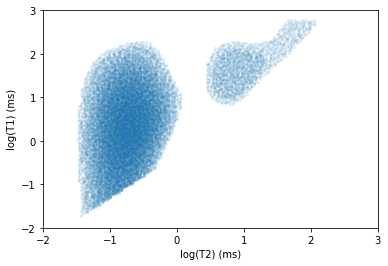

In [43]:
plot_Xtrain(X_train)

In [134]:
class NMR_clustering(object):
    def __init__(self, data_name='3_14_110c'):
        self.data_name = data_name
        self.t1_domain = None
        self.t2_domain = None
        self.t2_grid = None
        self.t1_grid = None
        self.f_grid = None
        self.X_train = None 
        self.X_manifold = None
        
        
    def load_data(self, file_t1 = 'data/T1_point.txt', file_t2 = 'data/T2_point.txt',
            file_fvol='data/T1T2_1_223_T110c.txt', verbose=0 ):
        self.t1_grid, self.t2_grid, self.f_grid = load_data(file_t1, file_t2, file_fvol, verbose)
    
    def preprocess(self, min_t1t2_ratio=0.5, t1_max = 600, fc=0.1, variation_length = 0.01, verbose=0, save=False):
        self.X_train, self.X_manifold = to_density(self.t2_grid, self.t1_grid, self.f_grid, 
            min_t1t2_ratio, t1_max, fc, variation_length, verbose)
        if save:
            np.savetxt('data_process/X_train_{}.txt'.format(self.data_name), self.X_train)
    def clustering(self, model_names = [], n_clusters=5, adjust_label = True, verbose=0):
        self.models = model_init(model_names = model_names, n_clusters= n_clusters, verbose=verbose)
        self.y_preds ={}
        for model in self.models:
            self.y_preds[model] = clustering(self.models[model], self.X_train, adjust_label = adjust_label, verbose=verbose)

In [144]:
nmr_cluster = NMR_clustering()
nmr_cluster.load_data(verbose=1)
nmr_cluster.preprocess(verbose=1, save=True)
nmr_cluster.clustering(['kmean'], n_clusters=5)

file info, Grid shape of [t1,t2]: (151, 121), log(t1) incremental: -0.03333, log(t2) incremental: -0.04167
Normalization : raw fluid volume 0.58462 , select fluid volume 0.47709, their ratio 0.816
X_trian shape:(16146, 2), X_manifold shape: (4143, 3)
adjust labels (remapping)


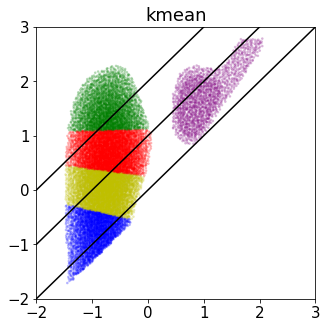

In [146]:
plot_clustering(nmr_cluster.X_train, nmr_cluster.y_preds['kmean'],model_name='kmean', plot_line=True,plot_save=False)